In [1]:
import pandas as pd
import numpy as np 
import scipy
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("finetuned_models_LTM.csv",index_col=0)
df["p_correct_relative"] = np.log(np.exp(df["p_correct"])/(np.exp(df["prob_A"])+np.exp(df["prob_B"])))
print(df["model_name"].unique())
model_names = [m_name.replace("llama3-8b-finetune","").replace("-v4-","epoch") for m_name in df["model_name"].unique()]

['llama3-8b-instruct' 'llama3-8b-finetune-v4-1' 'llama3-8b-finetune-v4-2'
 'llama3-8b-finetune-v4-3' 'llama3-8b-finetune-v4-4'
 'llama3-8b-finetune-v4-5' 'llama3-8b-finetune-v4-1-instruction-only'
 'llama3-8b-finetune-v4-2-instruction-only'
 'llama3-8b-finetune-v4-3-instruction-only'
 'llama3-8b-finetune-v4-4-instruction-only'
 'llama3-8b-finetune-v4-5-instruction-only'
 'llama3-8b-finetune-v4-1-summaries' 'llama3-8b-finetune-v4-2-summaries'
 'llama3-8b-finetune-v4-3-summaries' 'llama3-8b-finetune-v4-4-summaries'
 'llama3-8b-finetune-v4-5-summaries']


In [5]:
# Plot perplexities of the models after every epoch
for index in range(len(df["model_name"].unique())):
    #index = 4
    all_results = []
    fig, axs = plt.subplots(6, 4, figsize=(12, 18))
    for p_idx, present_first in enumerate([True, False]):
        results = {}
        for d_idx, distance_bin in enumerate(df.distance_bin.unique()):
    
            m_df = df[(df["model_name"] == df["model_name"].unique()[index])& (df["distance_bin"] == distance_bin) & (df["present_seg1_first"]==present_first)]
            axs[d_idx, p_idx].scatter(m_df["segment_A_perplexity"].values, m_df["p_correct_relative"].values,s=0.6)
            if p_idx == 0:
                axs[d_idx, p_idx].set_ylabel("Log-Probability of correct answer")
            if d_idx == len(df.distance_bin.unique())-1:
                axs[d_idx, p_idx].set_xlabel("Perplexity of Segment A")
            axs[d_idx, p_idx].set_title(f"{distance_bin},{present_first}, A")
            r = scipy.stats.pearsonr(m_df["p_correct_relative"].values, m_df["segment_A_perplexity"].values)
            results[distance_bin] = {"Segment A": (r.statistic, r.pvalue)}
            
            axs[d_idx, p_idx+2].scatter(m_df["segment_B_perplexity"].values, m_df["p_correct_relative"].values,s=0.6)
    
            if d_idx == len(df.distance_bin.unique())-1:
                axs[d_idx, p_idx+2].set_xlabel("Perplexity of Segment B")
            axs[d_idx, p_idx+2].set_title(f"{distance_bin},{present_first}, B")
            r = scipy.stats.pearsonr(m_df["p_correct_relative"].values, m_df["segment_B_perplexity"].values)
            results[distance_bin]["Segment B"] = (r.statistic, r.pvalue)

        all_results.append(results)
    plt.tight_layout()
    plt.savefig(f"Scatter_plots_{df['model_name'].unique()[index]}.pdf")
    plt.close()
    
    for results, present1_first  in zip(all_results, [True, False]):
        SegA_pearson_r = []
        SegA_significance = []
        
        SegB_pearson_r = []
        SegB_significance = []
        
        for distance in results.keys():
            pearson_r = results[distance]["Segment A"][0]
            pvalue = results[distance]["Segment A"][1]
            SegA_pearson_r.append(pearson_r)
            if pvalue <0.01:    
                SegA_significance.append("**")
            elif pvalue <0.05:
                SegA_significance.append("*")
            else:
                SegA_significance.append("")
            pearson_r = results[distance]["Segment B"][0]
            pvalue = results[distance]["Segment B"][1]
            SegB_pearson_r.append(pearson_r)
            if pvalue <0.01:    
                SegB_significance.append("**")
            elif pvalue <0.05:
                SegB_significance.append("*")
            else:
                SegB_significance.append("")
    
        a_color = "blue" if present1_first else "orange"
        plt.plot(np.arange(len(SegA_pearson_r)), SegA_pearson_r, color=a_color,label=f"Segment A, {present1_first}")
        
        for idx, s in enumerate(SegA_significance):
            plt.annotate(
                        s,  # Text of the annotation
                        xy=(idx, SegA_pearson_r[idx]+np.random.uniform(0.0005,0.002)),color=a_color )
        
        b_color = "lightblue" if present1_first else "gold"
        plt.plot(np.arange(len(SegB_pearson_r)), SegB_pearson_r, color=b_color, label=f"Segment B,{present1_first}")
        for idx, s in enumerate(SegB_significance):
            plt.annotate(s,  # Text of the annotation
                         xy=(idx, SegB_pearson_r[idx]+np.random.uniform(0.0005,0.002)),color=b_color)
        
        plt.xticks(np.arange(len(SegA_pearson_r)), df.distance_bin.unique())
        plt.xlabel("Distance bin (right side)")
        plt.ylabel("Pearson's R")
        #plt.title(f"corr. logprob(correct) and ppl(segment):\n{df['model_name'].unique()[index]}")
    plt.legend()    
    plt.savefig(f"correlation_{df['model_name'].unique()[index]}_p_correct_seg_ppl.pdf",metadata={"Title": f"{df['model_name'].unique()[index]} Correlation between log probability of the correct answer \nand segment perplexity across different distance bins,\n split across segment 1 presented first or second"})
    plt.close()

# McNemar's test on correctness and pairwise t-test on p(correct)

In [6]:
# COMPLETE DATA, not separated into distance bins and segment lengths
from statsmodels.stats.contingency_tables import mcnemar
books = [69087, 72578, 72600, 72869, 72958, 72972, 73017, 73042]

mcnemar_matrices = np.zeros((len(df["model_name"].unique()), len(df["model_name"].unique())))
pairwise_ttest_matrices = np.zeros((len(df["model_name"].unique()), len(df["model_name"].unique())))
for i in range(len(df["model_name"].unique())):
    for j in range(len(df["model_name"].unique())):
        model_name_1 = df["model_name"].unique()[i]
        model_name_2 = df["model_name"].unique()[j]
        print(model_name_1, model_name_2)

        #print(segment_length)
        df["book_in_list"] = df["book_idx"].apply(lambda x: True if x in books else False)
        model_1 = df[(df["model_name"]==model_name_1) &(df["book_in_list"] == True)]
        model_2 = df[(df["model_name"]==model_name_2) &(df["book_in_list"] == True)]
        
        assert len(model_1) == len(model_2), f"Need to have the same number of observations for both models. Got {len(model_1)} and {len(model_2)}"
        # McNemar's Test for correctness
        m1_vals = model_1["correct"].values
        m2_vals = model_2["correct"].values
        assert len(m1_vals) == len(m2_vals), "groups have different amounts of samples in this bin"
        both_correct = sum((m1_vals)&(m2_vals))
        m1_correct_m2_incorrect = sum((m1_vals)&(~m2_vals))
        m2_correct_m1_incorrect = sum((m2_vals)&(~m1_vals))
        both_incorrect =  sum((~m2_vals)&(~m1_vals))
        contingency_table = np.array([[both_correct, m1_correct_m2_incorrect],[m2_correct_m1_incorrect, both_incorrect]])
        result = mcnemar(contingency_table, exact=False)
        mcnemar_matrices[i,j] = result.pvalue

        # pairwise t-test for log probability of the correct answer
        m1_vals = model_1["p_correct_relative"].values
        m2_vals = model_2["p_correct_relative"].values
    
        assert len(m1_vals) == len(m2_vals), "groups have different amounts of samples in this bin"
        result = scipy.stats.ttest_rel(m1_vals, m2_vals,alternative="greater")
        pairwise_ttest_matrices[i,j] = result.pvalue

llama3-8b-instruct llama3-8b-instruct
llama3-8b-instruct llama3-8b-finetune-v4-1


C:\Users\MathisPink\anaconda3\envs\LLMs\lib\site-packages\statsmodels\stats\contingency_tables.py:1348: RuntimeWarning: divide by zero encountered in scalar divide
  statistic = (np.abs(n1 - n2) - corr)**2 / (1. * (n1 + n2))


llama3-8b-instruct llama3-8b-finetune-v4-2
llama3-8b-instruct llama3-8b-finetune-v4-3
llama3-8b-instruct llama3-8b-finetune-v4-4
llama3-8b-instruct llama3-8b-finetune-v4-5
llama3-8b-instruct llama3-8b-finetune-v4-1-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-2-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-3-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-4-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-5-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-1-summaries
llama3-8b-instruct llama3-8b-finetune-v4-2-summaries
llama3-8b-instruct llama3-8b-finetune-v4-3-summaries
llama3-8b-instruct llama3-8b-finetune-v4-4-summaries
llama3-8b-instruct llama3-8b-finetune-v4-5-summaries
llama3-8b-finetune-v4-1 llama3-8b-instruct
llama3-8b-finetune-v4-1 llama3-8b-finetune-v4-1
llama3-8b-finetune-v4-1 llama3-8b-finetune-v4-2
llama3-8b-finetune-v4-1 llama3-8b-finetune-v4-3
llama3-8b-finetune-v4-1 llama3-8b-finetune-v4-4
llama3-8b-finetune-v4-1 llam

In [57]:
for i in range(1,6):
    model_names[i]+="-books"

In [59]:
plt.figure(figsize=(20*0.7,16*0.7))
plt.subplots_adjust(bottom=0.2)
sns.heatmap(mcnemar_matrices, cmap="coolwarm",annot=True,fmt=".2f", center=0.001)
plt.xticks(np.arange(0,len(model_names)), model_names, rotation=67)
plt.yticks(np.arange(0,len(model_names)), model_names, rotation=0)
#plt.title(f"P-values from McNemar's pairwise statistical test on LTM-condition outcomes")
plt.savefig(f"McNemar_matrix.pdf")
plt.close()

plt.figure(figsize=(20*0.7,16*0.7))
plt.subplots_adjust(bottom=0.2)
sns.heatmap(pairwise_ttest_matrices, cmap="coolwarm",annot=True,fmt=".2f", center=0.001)
plt.xticks(np.arange(0,len(model_names)), model_names, rotation=67)
plt.yticks(np.arange(0,len(model_names)), model_names, rotation=0)
#plt.title(f"P-values from a pairwise t-test on LTM-condition log-probabilities of the correct answer")
plt.savefig(f"pairwise-ttest_matrix.pdf")
plt.close()

Same plots (pairwise t-test and McNemar's test) but split across different distance bins:

In [43]:
# SPLIT ACROSS SEGEMNT DISTANCES AND SEGMENT LENGTHS
from statsmodels.stats.contingency_tables import mcnemar
books = [69087, 72578, 72600, 72869, 72958, 72972, 73017, 73042]

mcnemar_matrices = np.zeros((len(df["model_name"].unique()), len(df["model_name"].unique()), len(df["distance_bin"].unique()), 2))
pairwise_ttest_matrices = np.zeros((len(df["model_name"].unique()), len(df["model_name"].unique()), len(df["distance_bin"].unique()), 2))
for i in range(len(df["model_name"].unique())):
    for j in range(len(df["model_name"].unique())):
        model_name_1 = df["model_name"].unique()[i]
        model_name_2 = df["model_name"].unique()[j]
        print(model_name_1, model_name_2)

        for s, segment_length in enumerate([20,50]):
            #print(segment_length)
            df["book_in_list"] = df["book_idx"].apply(lambda x: True if x in books else False)
            model_1 = df[(df["segment_length"] == segment_length)&(df["model_name"]==model_name_1) &(df["book_in_list"] == True)]
            model_2 = df[(df["segment_length"] == segment_length)&(df["model_name"]==model_name_2) &(df["book_in_list"] == True)]
            
            assert len(model_1) == len(model_2), f"Need to have the same number of observations for both models. Got {len(model_1)} and {len(model_2)}"
            # McNemar's Test for correctness
            m1_groups = model_1.groupby("distance_bin")["correct"]
            m2_groups = model_2.groupby("distance_bin")["correct"]
            for d, (m1_group, m2_group) in enumerate(zip(m1_groups, m2_groups)):
                m1_vals = m1_group[1].values
                m2_vals = m2_group[1].values
                assert len(m1_vals) == len(m2_vals), "groups have different amounts of samples in this bin"
                assert m1_group[0] == m2_group[0], "distance bins are not the same"
                #print("McNemar's Test for distance bin", m1_group[0])
                both_correct = sum((m1_vals)&(m2_vals))
                m1_correct_m2_incorrect = sum((m1_vals)&(~m2_vals))
                m2_correct_m1_incorrect = sum((m2_vals)&(~m1_vals))
                both_incorrect =  sum((~m2_vals)&(~m1_vals))
                contingency_table = np.array([[both_correct, m1_correct_m2_incorrect],[m2_correct_m1_incorrect, both_incorrect]])
                assert np.sum(np.sum(contingency_table)) == len(m1_group[1])==len(m2_group[1]), "different number of samples in contingency table than in model data"
                result = mcnemar(contingency_table, exact=False)
                mcnemar_matrices[i,j,d,s] = result.pvalue

            # pairwise t-test for log probability of the correct answer
            m1_groups = model_1.groupby("distance_bin")["p_correct_relative"]
            m2_groups = model_2.groupby("distance_bin")["p_correct_relative"]

            for d, (m1_group, m2_group) in enumerate(zip(m1_groups, m2_groups)):
                m1_vals = m1_group[1].values
                m2_vals = m2_group[1].values
                assert len(m1_vals) == len(m2_vals), "groups have different amounts of samples in this bin"
                assert m1_group[0] == m2_group[0], "distance bins are not the same"
                result = scipy.stats.ttest_rel(m1_vals, m2_vals,alternative="greater")
                pairwise_ttest_matrices[i,j,d,s] = result.pvalue

llama3-8b-instruct llama3-8b-instruct


C:\Users\MathisPink\anaconda3\envs\LLMs\lib\site-packages\statsmodels\stats\contingency_tables.py:1348: RuntimeWarning: divide by zero encountered in scalar divide
  statistic = (np.abs(n1 - n2) - corr)**2 / (1. * (n1 + n2))


llama3-8b-instruct llama3-8b-finetune-v4-1
llama3-8b-instruct llama3-8b-finetune-v4-2
llama3-8b-instruct llama3-8b-finetune-v4-3
llama3-8b-instruct llama3-8b-finetune-v4-4
llama3-8b-instruct llama3-8b-finetune-v4-5
llama3-8b-instruct llama3-8b-finetune-v4-1-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-2-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-3-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-4-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-5-instruction-only
llama3-8b-instruct llama3-8b-finetune-v4-1-summaries
llama3-8b-instruct llama3-8b-finetune-v4-2-summaries
llama3-8b-instruct llama3-8b-finetune-v4-3-summaries
llama3-8b-instruct llama3-8b-finetune-v4-4-summaries
llama3-8b-instruct llama3-8b-finetune-v4-5-summaries
llama3-8b-finetune-v4-1 llama3-8b-instruct
llama3-8b-finetune-v4-1 llama3-8b-finetune-v4-1
llama3-8b-finetune-v4-1 llama3-8b-finetune-v4-2
llama3-8b-finetune-v4-1 llama3-8b-finetune-v4-3
llama3-8b-finetune-v4-1 llama3-8b

In [7]:
# plots separated across d
if False:
    distances = df.distance_bin.unique()
    for d_idx in range(len(distances)):
        for s_idx in range(2):
            plt.figure(figsize=(20*0.7,16*0.7))
            plt.subplots_adjust(bottom=0.2)
            sns.heatmap(mcnemar_matrices[:,:,idx,s_idx], cmap="coolwarm",annot=True,fmt=".2f", center=0.001)
            plt.xticks(np.arange(0,len(model_names)), model_names, rotation=67)
            plt.yticks(np.arange(0,len(model_names)), model_names, rotation=0)
            plt.title(f"P-values from McNemar's pairwise statistical test on LTM-condition outcomes, for distance bin {distances[d_idx]} and segments of {[20,50][s_idx]} words")
            plt.savefig(f"McNemar_matrix_{distances[d_idx]}_{[20,50][s_idx]}.pdf")
            plt.show()
            plt.close()
    distances = df.distance_bin.unique()
    for d_idx in range(len(distances)):
        for s_idx in range(2):
            plt.figure(figsize=(20*0.7,16*0.7))
            plt.subplots_adjust(bottom=0.2)
            sns.heatmap(pairwise_ttest_matrices[:,:,idx,s_idx], cmap="coolwarm",annot=True,fmt=".2f", center=0.001)
            plt.xticks(np.arange(0,len(model_names)), model_names, rotation=67)
            plt.yticks(np.arange(0,len(model_names)), model_names, rotation=0)
            plt.title(f"P-values from a pairwise t-test on LTM-condition outcomes, for distance bin {distances[d_idx]} and segments of {[20,50][s_idx]} words")
            plt.savefig(f"pairwise-ttest_matrix_{distances[d_idx]}_{[20,50][s_idx]}.pdf")
            plt.show()
            plt.close()

## Accuracies and log probability across epochs

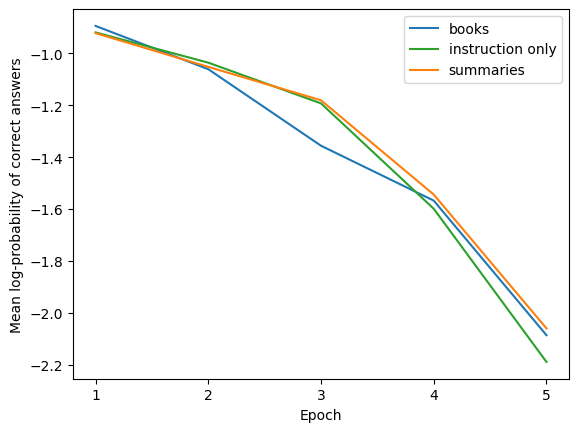

In [9]:
# plot accuracies across epochs
p_correct_mean = np.zeros((len(df["model_name"].unique()), (len(df["distance_bin"].unique())), 2))
p_correct_mean_all_distances = np.zeros((len(df["model_name"].unique())))
for i in range(len(df["model_name"].unique())):
    model_name = df["model_name"].unique()[i]
    df["book_in_list"] = df["book_idx"].apply(lambda x: True if x in books else False)
    model = df[(df["model_name"]==model_name) &(df["book_in_list"] == True)]        
    p_correct_mean_all_distances[i] = model["p_correct_relative"].values.mean()
    for s, segment_length in enumerate([20,50]):
        #print(segment_length)
        df["book_in_list"] = df["book_idx"].apply(lambda x: True if x in books else False)
        model = df[(df["segment_length"] == segment_length)&(df["model_name"]==model_name) &(df["book_in_list"] == True)]        

        groups = model.groupby("distance_bin")["p_correct_relative"]
        for d, gr in enumerate(groups):
            vals = gr[1].values
            p_correct_mean[i,d,s] = vals.mean()
b_indices = np.array([1,2,3,4,5]) # indices in the model names list corresponding to the books-finetuned model
i_indices = np.array([6,7,8,9,10])
s_indices = np.array([11,12,13,14,15])

plt.plot(p_correct_mean_all_distances[b_indices], label="books", color="#1f77b4")
plt.plot(p_correct_mean_all_distances[i_indices], label="instruction only", color='#2ca02c')
plt.plot(p_correct_mean_all_distances[s_indices], label="summaries", color='#ff7f0e')

plt.legend()
plt.xlabel("Epoch")
#plt.title("Log-probability of correct answer across epochs of fine-tuning")
plt.ylabel("Mean log-probability of correct answers")
plt.xticks(np.arange(0,5), np.arange(1,6))
plt.savefig("logprob_change_across_epochs.pdf")
plt.show()
plt.close()

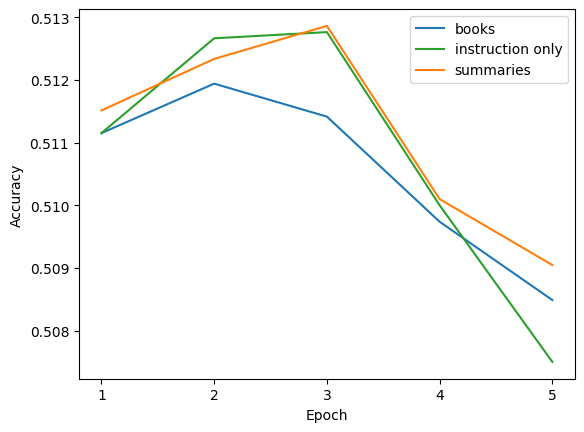

In [10]:
# line plot of performance in terms of mean correctness across epochs
acc = np.zeros((len(df["model_name"].unique()), (len(df["distance_bin"].unique())), 2))
acc_all_distances = np.zeros((len(df["model_name"].unique())))
for i in range(len(df["model_name"].unique())):
    model_name = df["model_name"].unique()[i]
    df["book_in_list"] = df["book_idx"].apply(lambda x: True if x in books else False)
    model = df[(df["model_name"]==model_name) &(df["book_in_list"] == True)]        
    acc_all_distances[i] = model["correct"].values.mean()
    for s, segment_length in enumerate([20,50]):
        #print(segment_length)
        df["book_in_list"] = df["book_idx"].apply(lambda x: True if x in books else False)
        model = df[(df["segment_length"] == segment_length)&(df["model_name"]==model_name) &(df["book_in_list"] == True)]        

        groups = model.groupby("distance_bin")["correct"]
        for d, gr in enumerate(groups):
            vals = gr[1].values
            acc[i,d,s] = vals.mean()

b_indices = np.array([1,2,3,4,5]) # indices in the model names list corresponding to the books-finetuned model
i_indices = np.array([6,7,8,9,10])
s_indices = np.array([11,12,13,14,15])

plt.plot(acc_all_distances[b_indices], label="books", color="#1f77b4")
plt.plot(acc_all_distances[i_indices], label="instruction only", color='#2ca02c')
plt.plot(acc_all_distances[s_indices], label="summaries", color='#ff7f0e')

plt.legend()
plt.xlabel("Epoch")
#plt.title("Accuracy across epochs of fine-tuning")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0,5), np.arange(1,6))
plt.savefig("accuracy_across_epochs.pdf")
plt.show()
plt.close()

## Plot perplexity of segment A and segment B for every epoch.

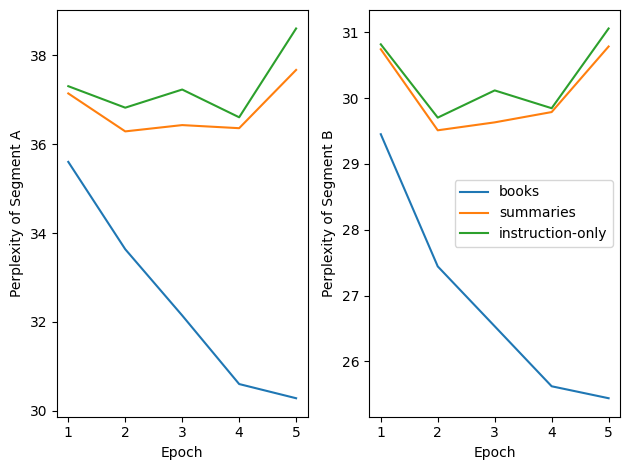

In [11]:
# make perplexity plot
perplexities_A_books= []
perplexities_A_summaries= []
perplexities_A_instructions= []
base_perplexity_A = []
groups = df.groupby("model_name")["segment_A_perplexity"]
for group in groups:
    if "summaries" in group[0]:
        perplexities_A_summaries.append(group[1].mean())
    elif "instruction" in group[0]:
        perplexities_A_instructions.append(group[1].mean())
    elif "finetune" in group[0]:
        perplexities_A_books.append(group[1].mean())
    else:
        base_perplexity_A.append(group[1].mean())
    #group[1].plot()

perplexities_B_books= []
perplexities_B_summaries= []
perplexities_B_instructions= []
base_perplexity_B = []
groups = df.groupby("model_name")["segment_B_perplexity"]
for group in groups:
    if "summaries" in group[0]:
        perplexities_B_summaries.append(group[1].mean())
    elif "instruction" in group[0]:
        perplexities_B_instructions.append(group[1].mean())
    elif "finetune" in group[0]:
        perplexities_B_books.append(group[1].mean())
    else:
        base_perplexity_B.append(group[1].mean())


fig, ax = plt.subplots(nrows=1,ncols=2)

ax[0].plot(perplexities_A_books,label="books", color="#1f77b4")
ax[0].plot(perplexities_A_summaries, label="summaries",color='#ff7f0e')
ax[0].plot(perplexities_A_instructions, label="instruction-only",color='#2ca02c')
ax[0].set_xticks(np.arange(0,5), np.arange(1,6))
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Perplexity of Segment A")
#plt.show()

ax[1].plot(perplexities_B_books,label="books",color="#1f77b4")
ax[1].plot(perplexities_B_summaries, label="summaries",color='#ff7f0e')
ax[1].plot(perplexities_B_instructions, label="instruction-only",color='#2ca02c')
ax[1].set_xticks(np.arange(0,5), np.arange(1,6))
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Perplexity of Segment B")
plt.tight_layout()
plt.legend()
plt.savefig("segment_perplexity_finetuning.pdf")
plt.show()
plt.close()